In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import pandas as pd
import deepchem as dc
import os
from tqdm import tqdm
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool
from torch.nn import BatchNorm1d

C:\Users\Y-8874903-E.ESTUDIANT\Anaconda3\envs\MLenv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
class GCNLayer(nn.Module):
    
    def __init__(self,in_feats,out_feats,batch_norm=True):
        
        super().__init__()
        
        self.graph_conv = GCNConv(in_channels=in_feats,out_channels=out_feats)
        self.dropout = nn.Dropout(p=0.6)
        self.batch_norm = batch_norm
        ## implementing residual
        self.res_connection = nn.Linear(in_feats,out_feats)
        
        ## implementing BatchNorm
        if self.batch_norm:
            self.bn = BatchNorm1d(out_feats)
        
    def reset_parameters(self):
        """Reinitialize model parameters."""
        self.graph_conv.reset_parameters()
        self.res_connection.reset_parameters()
      
        
        
    def forward(self,x,edge_index):
        
        ### Extracting data from batch
        new_feats = self.graph_conv(x,edge_index)
        res_feats = F.relu(self.res_connection(x))
        new_feats = new_feats + res_feats ### residual added
        
        new_feats = self.dropout(new_feats)
        
        if self.batch_norm:
            return self.bn(new_feats)
        else:
            return new_feats

In [4]:
class GCNNetwork(nn.Module):
    
    def __init__(self,):
        
        super().__init__()
        
        ## GCN layers
        self.GCNConv1 = GCNLayer(30,64,True)
        self.GCNConv2 = GCNLayer(64,32,False)
#         self.GCNConv3 = GCNLayer(64,32)
        
        
        
        ### Predictor layers
        self.lin1 = nn.Linear(32,128)
        self.lin2 = nn.Linear(128,1)
        
        
    def forward(self,data):
        
        batch, x, edge_index, edge_attr = (data.batch, data.x, data.edge_index, data.edge_attr)
        
        x = F.relu(self.GCNConv1(x,edge_index))
        x = F.relu(self.GCNConv2(x,edge_index))
#         x = F.dropout(x, p=0.6, training=self.training)
#         x = F.relu(self.GCNConv3(x,edge_index))
#         x = F.dropout(x, p=0.6, training=self.training)
        
        x = global_mean_pool(x,batch)
        
        x = F.relu(self.lin1(x))
#         x = F.dropout(x, p=0.6, training=self.training)
        x = torch.sigmoid(self.lin2(x))
        
        return x      

In [5]:
clean_data = pd.read_csv(r"Data.csv")

In [6]:
data = clean_data

In [7]:
from torch_geometric.data import Dataset, Data
from torch_geometric.loader import DataLoader

In [8]:
class BBBDataset(Dataset):
    
    def __init__(self,root,transform=None,pre_transform=None,pre_filter=None):
        
        super().__init__(root, transform, pre_transform, pre_filter)
        
        
        
    @property
    def raw_file_names(self):
        
        """
        If this file exists in raw_dir, the download is not triggered
        """
        return "data.csv"
        
    def download(self):
        pass
    
    @property
    def processed_file_names(self):
        return ['data.pt']
    
    
    def process(self):
        
        self.data = pd.read_csv(self.raw_paths[0])
        smiles = self.data.SMILES.to_list()
        labels = self.data.LABELS.to_list()
        
        featurizer = dc.feat.MolGraphConvFeaturizer() ## Feature calculator
        
        X = featurizer.featurize(smiles)
        
        j=0
        for idx, Gdata in tqdm(enumerate(X)):
            
            pyG_data = Gdata
            
            nodes = torch.tensor(pyG_data.node_features,dtype= torch.float32)
            
            Edge_index = torch.tensor(pyG_data.edge_index,dtype= torch.int64 )
            #Edge_feats = torch.tensor(pyG_data.edge_features,dtype=torch.float32)
            y = torch.tensor([labels[idx]],dtype= torch.float32 )
            ### create data object
            data = Data(x=nodes,edge_index=Edge_index,y=y,smiles=smiles[idx])
            torch.save(data,os.path.join(self.processed_dir,f"data_{j}.pt"))
            j+=1
            
    def len (self):
        return self.data.shape[0]
    
    def get(self,idx):
        data = torch.load(os.path.join(self.processed_dir,f'data_{idx}.pt'))
        return data


In [9]:
dataset = BBBDataset(root=".",)

Processing...
3330it [00:02, 1370.55it/s]
Done!


### Trying to implement weight and sum

In [ ]:
class WeightSum(nn.Module):
    
    def __init__(self,in_feats):
        
        super().__init__()
        self.in_feats = in_feats
        
        self.atom_weighting = nn.Sequential(
        nn.Linear(in_feats,1),
        nn.sigmoid())
        
    def forward(self,g,feats):
            g.ndata["h"] = feats
            g.ndata["w"] = self.atom_weighting(g.ndata["h"])
            h_g_sum = sum_nodes(g,"h","w")
            
        return h_g_sum

In [16]:
### Splitting of data
from torch.utils.data import random_split

train_set, valid_set, test_set = random_split(dataset,[2331,333,666])

trainloader = DataLoader(train_set,shuffle=True,batch_size=256,)

validloader = DataLoader(valid_set, shuffle=True,batch_size=256,)

testloader = DataLoader(test_set, shuffle=True,batch_size=256,)

In [17]:
from torch.nn import BCEWithLogitsLoss, BCELoss,CrossEntropyLoss, Softmax

## Intilaize Network
net = GCNNetwork()

### initialize an optimizer with someparameters
optimizer = torch.optim.Adam(net.parameters(), lr=0.001,) ## Weight decay might be reason for low validation loss than training


### Defining loss
criterion = BCELoss()

### criterion
criterion.cuda()

## shifting to GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
net.to(device)

GCNNetwork(
  (GCNConv1): GCNLayer(
    (graph_conv): GCNConv(30, 64)
    (dropout): Dropout(p=0.6, inplace=False)
    (res_connection): Linear(in_features=30, out_features=64, bias=True)
    (bn): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (GCNConv2): GCNLayer(
    (graph_conv): GCNConv(64, 32)
    (dropout): Dropout(p=0.6, inplace=False)
    (res_connection): Linear(in_features=64, out_features=32, bias=True)
  )
  (lin1): Linear(in_features=32, out_features=128, bias=True)
  (lin2): Linear(in_features=128, out_features=1, bias=True)
)

In [18]:
from sklearn.metrics import accuracy_score

In [19]:
def accuracy_counter(y_prob,y_true):
    
    y_prob = np.array(y_prob)
    y_prob = np.where(y_prob <= 0.5, 0, y_prob)
    y_prob = np.where(y_prob > 0.5, 1, y_prob)
    accuracy = accuracy_score(np.array(y_true),y_prob)
    
    return (accuracy,)

In [22]:
def train():
    
    net.train() ### training mode
    
    y_true = []
    proab = []
    train_loss = []
    for data in trainloader:## Iterate in batches over training dataset
        data.to(device)
        
        optimizer.zero_grad() ## clear gradients
        out = net(data).squeeze(0) ## single forward pass
        
        proab.extend(out.detach().cpu().numpy().squeeze().tolist()) ## appending to list each batch
        y_true.extend(data.y.unsqueeze(1).squeeze().tolist()) ## appending true value of each batch
        
        loss = criterion(out,data.y.unsqueeze(1)) ## compute the loss
        
        train_loss.append(loss)
        
        loss.backward() ## Derive gradients
        optimizer.step()## update parameters based on gradients
        
    av_loss = torch.sum(torch.tensor(train_loss))/len(trainloader)
    
    accuracy = accuracy_counter(proab,y_true)
    
    return (av_loss,accuracy)
        

In [23]:
@torch.no_grad()
def test(loader):
    
    net.eval() #### evaluation mode
    
    y_true = []
    proab = []
    val_loss = []
    for data in loader:## Iterate in batches over training dataset
        data.to(device)
        out = net(data).squeeze(0) ## single forward pass
        
        proab.extend(out.detach().cpu().numpy().squeeze().tolist()) ## appending to list each batch
        y_true.extend(data.y.unsqueeze(1).squeeze().tolist()) ## appending true value of each batch
    
        loss = criterion(out,data.y.unsqueeze(1))
        val_loss.append(loss)
        
    val = torch.sum(torch.tensor(val_loss))/len(loader)
    accuracy = accuracy_counter(proab,y_true)
    return (val,accuracy)

In [24]:

import numpy as np
epochs = 1000

## Accuracy
traine_accuracy = []
vale_accuracy = []
teste_accuracy = []

## Loss
epoch_loss = []
valida_loss = []
test_loss_full = []

for epoch in range(1,epochs):
    
    train_loss1,train_accuracy1 = train()
    
    train_loss2,train_accuracy2 = test(trainloader)
    
    val_loss,val_accuracy = test(validloader)
    
    test_loss,test_accuracy = test(testloader)
    
    ##losses
    epoch_loss.append(train_loss1)
    valida_loss.append(val_loss)
    test_loss_full.append(test_loss)
    
    ## accuracy
    traine_accuracy.append(train_accuracy1[0])
    vale_accuracy.append(val_accuracy[0])
    teste_accuracy.append(test_accuracy[0])
    
    print(f'Epoch: {epoch:03d}, Train loss: {train_loss1:.4f}, Train accuracy: {train_accuracy1[0]:.4f}, val loss: {val_loss:.4f}, val accuracy: {val_accuracy[0]:.4f}')

Epoch: 001, Train loss: 0.6731, Train accuracy: 0.5946, val loss: 0.6726, val accuracy: 0.6006
Epoch: 002, Train loss: 0.6744, Train accuracy: 0.6049, val loss: 0.6687, val accuracy: 0.6006
Epoch: 003, Train loss: 0.6626, Train accuracy: 0.6049, val loss: 0.6621, val accuracy: 0.6006
Epoch: 004, Train loss: 0.6621, Train accuracy: 0.6049, val loss: 0.6498, val accuracy: 0.6006
Epoch: 005, Train loss: 0.6395, Train accuracy: 0.6100, val loss: 0.6369, val accuracy: 0.6396
Epoch: 006, Train loss: 0.6439, Train accuracy: 0.6336, val loss: 0.6132, val accuracy: 0.7087
Epoch: 007, Train loss: 0.6233, Train accuracy: 0.6637, val loss: 0.6063, val accuracy: 0.7057
Epoch: 008, Train loss: 0.6160, Train accuracy: 0.6654, val loss: 0.5843, val accuracy: 0.7267
Epoch: 009, Train loss: 0.6026, Train accuracy: 0.6834, val loss: 0.5884, val accuracy: 0.7327
Epoch: 010, Train loss: 0.5972, Train accuracy: 0.6946, val loss: 0.6108, val accuracy: 0.7387
Epoch: 011, Train loss: 0.5980, Train accuracy: 0.

Epoch: 088, Train loss: 0.5022, Train accuracy: 0.7602, val loss: 0.5014, val accuracy: 0.7508
Epoch: 089, Train loss: 0.5015, Train accuracy: 0.7499, val loss: 0.4842, val accuracy: 0.7748
Epoch: 090, Train loss: 0.5148, Train accuracy: 0.7589, val loss: 0.5053, val accuracy: 0.7778
Epoch: 091, Train loss: 0.5081, Train accuracy: 0.7559, val loss: 0.5149, val accuracy: 0.7538
Epoch: 092, Train loss: 0.5166, Train accuracy: 0.7323, val loss: 0.4804, val accuracy: 0.7688
Epoch: 093, Train loss: 0.5175, Train accuracy: 0.7533, val loss: 0.5267, val accuracy: 0.7538
Epoch: 094, Train loss: 0.5062, Train accuracy: 0.7486, val loss: 0.4848, val accuracy: 0.7718
Epoch: 095, Train loss: 0.5184, Train accuracy: 0.7546, val loss: 0.4900, val accuracy: 0.7568
Epoch: 096, Train loss: 0.5077, Train accuracy: 0.7550, val loss: 0.4883, val accuracy: 0.7808
Epoch: 097, Train loss: 0.5048, Train accuracy: 0.7572, val loss: 0.4683, val accuracy: 0.7778
Epoch: 098, Train loss: 0.5127, Train accuracy: 0.

Epoch: 175, Train loss: 0.4830, Train accuracy: 0.7718, val loss: 0.4676, val accuracy: 0.7748
Epoch: 176, Train loss: 0.4815, Train accuracy: 0.7649, val loss: 0.5038, val accuracy: 0.7688
Epoch: 177, Train loss: 0.4654, Train accuracy: 0.7640, val loss: 0.4799, val accuracy: 0.7658
Epoch: 178, Train loss: 0.4669, Train accuracy: 0.7812, val loss: 0.4713, val accuracy: 0.7748
Epoch: 179, Train loss: 0.4552, Train accuracy: 0.7765, val loss: 0.5003, val accuracy: 0.7658
Epoch: 180, Train loss: 0.4726, Train accuracy: 0.7752, val loss: 0.4888, val accuracy: 0.7538
Epoch: 181, Train loss: 0.4777, Train accuracy: 0.7653, val loss: 0.4754, val accuracy: 0.7718
Epoch: 182, Train loss: 0.4838, Train accuracy: 0.7718, val loss: 0.5233, val accuracy: 0.7778
Epoch: 183, Train loss: 0.4948, Train accuracy: 0.7765, val loss: 0.4601, val accuracy: 0.7658
Epoch: 184, Train loss: 0.4737, Train accuracy: 0.7829, val loss: 0.4420, val accuracy: 0.7628
Epoch: 185, Train loss: 0.4663, Train accuracy: 0.

Epoch: 262, Train loss: 0.4524, Train accuracy: 0.7889, val loss: 0.5127, val accuracy: 0.7598
Epoch: 263, Train loss: 0.4526, Train accuracy: 0.7825, val loss: 0.5031, val accuracy: 0.7568
Epoch: 264, Train loss: 0.4501, Train accuracy: 0.7864, val loss: 0.4994, val accuracy: 0.7598
Epoch: 265, Train loss: 0.4475, Train accuracy: 0.7876, val loss: 0.5027, val accuracy: 0.7658
Epoch: 266, Train loss: 0.4454, Train accuracy: 0.7825, val loss: 0.5362, val accuracy: 0.7417
Epoch: 267, Train loss: 0.4434, Train accuracy: 0.7838, val loss: 0.5105, val accuracy: 0.7447
Epoch: 268, Train loss: 0.4816, Train accuracy: 0.7812, val loss: 0.4845, val accuracy: 0.7718
Epoch: 269, Train loss: 0.4645, Train accuracy: 0.7795, val loss: 0.4879, val accuracy: 0.7808
Epoch: 270, Train loss: 0.4591, Train accuracy: 0.7898, val loss: 0.5159, val accuracy: 0.7778
Epoch: 271, Train loss: 0.4727, Train accuracy: 0.7876, val loss: 0.5185, val accuracy: 0.7658
Epoch: 272, Train loss: 0.4650, Train accuracy: 0.

Epoch: 349, Train loss: 0.4417, Train accuracy: 0.7894, val loss: 0.5096, val accuracy: 0.7417
Epoch: 350, Train loss: 0.4339, Train accuracy: 0.7881, val loss: 0.5294, val accuracy: 0.7417
Epoch: 351, Train loss: 0.4405, Train accuracy: 0.7924, val loss: 0.5330, val accuracy: 0.7417
Epoch: 352, Train loss: 0.4628, Train accuracy: 0.7915, val loss: 0.5140, val accuracy: 0.7628
Epoch: 353, Train loss: 0.4375, Train accuracy: 0.8005, val loss: 0.5172, val accuracy: 0.7568
Epoch: 354, Train loss: 0.4411, Train accuracy: 0.7997, val loss: 0.5132, val accuracy: 0.7628
Epoch: 355, Train loss: 0.4474, Train accuracy: 0.7932, val loss: 0.5169, val accuracy: 0.7538
Epoch: 356, Train loss: 0.4385, Train accuracy: 0.8001, val loss: 0.4959, val accuracy: 0.7568
Epoch: 357, Train loss: 0.4592, Train accuracy: 0.7782, val loss: 0.4549, val accuracy: 0.7477
Epoch: 358, Train loss: 0.4581, Train accuracy: 0.7846, val loss: 0.4878, val accuracy: 0.7387
Epoch: 359, Train loss: 0.4413, Train accuracy: 0.

Epoch: 436, Train loss: 0.4477, Train accuracy: 0.7919, val loss: 0.5114, val accuracy: 0.7568
Epoch: 437, Train loss: 0.4282, Train accuracy: 0.8082, val loss: 0.5703, val accuracy: 0.7568
Epoch: 438, Train loss: 0.4282, Train accuracy: 0.8087, val loss: 0.4994, val accuracy: 0.7718
Epoch: 439, Train loss: 0.4276, Train accuracy: 0.7988, val loss: 0.4971, val accuracy: 0.7628
Epoch: 440, Train loss: 0.4265, Train accuracy: 0.7971, val loss: 0.5049, val accuracy: 0.7508
Epoch: 441, Train loss: 0.4308, Train accuracy: 0.7919, val loss: 0.5189, val accuracy: 0.7417
Epoch: 442, Train loss: 0.4275, Train accuracy: 0.7945, val loss: 0.5368, val accuracy: 0.7477
Epoch: 443, Train loss: 0.4517, Train accuracy: 0.7915, val loss: 0.4891, val accuracy: 0.7447
Epoch: 444, Train loss: 0.4281, Train accuracy: 0.8082, val loss: 0.5329, val accuracy: 0.7387
Epoch: 445, Train loss: 0.4564, Train accuracy: 0.7954, val loss: 0.5249, val accuracy: 0.7357
Epoch: 446, Train loss: 0.4417, Train accuracy: 0.

Epoch: 523, Train loss: 0.4250, Train accuracy: 0.7997, val loss: 0.5388, val accuracy: 0.7568
Epoch: 524, Train loss: 0.4233, Train accuracy: 0.8005, val loss: 0.4833, val accuracy: 0.7477
Epoch: 525, Train loss: 0.4305, Train accuracy: 0.7954, val loss: 0.5118, val accuracy: 0.7568
Epoch: 526, Train loss: 0.4345, Train accuracy: 0.7988, val loss: 0.5297, val accuracy: 0.7568
Epoch: 527, Train loss: 0.4363, Train accuracy: 0.8027, val loss: 0.4883, val accuracy: 0.7447
Epoch: 528, Train loss: 0.4386, Train accuracy: 0.8039, val loss: 0.5115, val accuracy: 0.7568
Epoch: 529, Train loss: 0.4339, Train accuracy: 0.8061, val loss: 0.5271, val accuracy: 0.7628
Epoch: 530, Train loss: 0.4243, Train accuracy: 0.7992, val loss: 0.5541, val accuracy: 0.7508
Epoch: 531, Train loss: 0.4271, Train accuracy: 0.8048, val loss: 0.5170, val accuracy: 0.7538
Epoch: 532, Train loss: 0.4252, Train accuracy: 0.8022, val loss: 0.5579, val accuracy: 0.7508
Epoch: 533, Train loss: 0.4183, Train accuracy: 0.

Epoch: 610, Train loss: 0.4200, Train accuracy: 0.8087, val loss: 0.5410, val accuracy: 0.7508
Epoch: 611, Train loss: 0.4274, Train accuracy: 0.8035, val loss: 0.5243, val accuracy: 0.7628
Epoch: 612, Train loss: 0.4244, Train accuracy: 0.8065, val loss: 0.4836, val accuracy: 0.7688
Epoch: 613, Train loss: 0.4266, Train accuracy: 0.7992, val loss: 0.4601, val accuracy: 0.7658
Epoch: 614, Train loss: 0.4143, Train accuracy: 0.8035, val loss: 0.5604, val accuracy: 0.7688
Epoch: 615, Train loss: 0.4225, Train accuracy: 0.8039, val loss: 0.4872, val accuracy: 0.7538
Epoch: 616, Train loss: 0.4253, Train accuracy: 0.8130, val loss: 0.5420, val accuracy: 0.7718
Epoch: 617, Train loss: 0.4225, Train accuracy: 0.8177, val loss: 0.5445, val accuracy: 0.7598
Epoch: 618, Train loss: 0.4167, Train accuracy: 0.8057, val loss: 0.4685, val accuracy: 0.7568
Epoch: 619, Train loss: 0.4159, Train accuracy: 0.8095, val loss: 0.5547, val accuracy: 0.7508
Epoch: 620, Train loss: 0.4129, Train accuracy: 0.

Epoch: 697, Train loss: 0.4186, Train accuracy: 0.8125, val loss: 0.5015, val accuracy: 0.7568
Epoch: 698, Train loss: 0.4195, Train accuracy: 0.8069, val loss: 0.5902, val accuracy: 0.7568
Epoch: 699, Train loss: 0.4083, Train accuracy: 0.8095, val loss: 0.5089, val accuracy: 0.7598
Epoch: 700, Train loss: 0.4134, Train accuracy: 0.7971, val loss: 0.5455, val accuracy: 0.7538
Epoch: 701, Train loss: 0.4019, Train accuracy: 0.8095, val loss: 0.4822, val accuracy: 0.7538
Epoch: 702, Train loss: 0.4196, Train accuracy: 0.8005, val loss: 0.5692, val accuracy: 0.7598
Epoch: 703, Train loss: 0.4166, Train accuracy: 0.8095, val loss: 0.5782, val accuracy: 0.7508
Epoch: 704, Train loss: 0.4290, Train accuracy: 0.8018, val loss: 0.4508, val accuracy: 0.7688
Epoch: 705, Train loss: 0.4060, Train accuracy: 0.8095, val loss: 0.4848, val accuracy: 0.7628
Epoch: 706, Train loss: 0.4074, Train accuracy: 0.8168, val loss: 0.5141, val accuracy: 0.7598
Epoch: 707, Train loss: 0.4098, Train accuracy: 0.

Epoch: 784, Train loss: 0.4134, Train accuracy: 0.8061, val loss: 0.5669, val accuracy: 0.7568
Epoch: 785, Train loss: 0.4133, Train accuracy: 0.8091, val loss: 0.5146, val accuracy: 0.7628
Epoch: 786, Train loss: 0.4168, Train accuracy: 0.8095, val loss: 0.5369, val accuracy: 0.7658
Epoch: 787, Train loss: 0.4180, Train accuracy: 0.8100, val loss: 0.5570, val accuracy: 0.7658
Epoch: 788, Train loss: 0.4115, Train accuracy: 0.8108, val loss: 0.4950, val accuracy: 0.7568
Epoch: 789, Train loss: 0.4092, Train accuracy: 0.8207, val loss: 0.5154, val accuracy: 0.7658
Epoch: 790, Train loss: 0.4135, Train accuracy: 0.8112, val loss: 0.5094, val accuracy: 0.7508
Epoch: 791, Train loss: 0.4216, Train accuracy: 0.8035, val loss: 0.5100, val accuracy: 0.7538
Epoch: 792, Train loss: 0.4135, Train accuracy: 0.8095, val loss: 0.5370, val accuracy: 0.7628
Epoch: 793, Train loss: 0.4347, Train accuracy: 0.8074, val loss: 0.4886, val accuracy: 0.7628
Epoch: 794, Train loss: 0.4048, Train accuracy: 0.

Epoch: 871, Train loss: 0.4151, Train accuracy: 0.8078, val loss: 0.5428, val accuracy: 0.7658
Epoch: 872, Train loss: 0.4092, Train accuracy: 0.8087, val loss: 0.5179, val accuracy: 0.7508
Epoch: 873, Train loss: 0.4087, Train accuracy: 0.8091, val loss: 0.5417, val accuracy: 0.7628
Epoch: 874, Train loss: 0.4041, Train accuracy: 0.8202, val loss: 0.5160, val accuracy: 0.7628
Epoch: 875, Train loss: 0.4198, Train accuracy: 0.8147, val loss: 0.6053, val accuracy: 0.7568
Epoch: 876, Train loss: 0.4257, Train accuracy: 0.8039, val loss: 0.5578, val accuracy: 0.7598
Epoch: 877, Train loss: 0.4096, Train accuracy: 0.8134, val loss: 0.5161, val accuracy: 0.7628
Epoch: 878, Train loss: 0.4063, Train accuracy: 0.8160, val loss: 0.5585, val accuracy: 0.7598
Epoch: 879, Train loss: 0.4211, Train accuracy: 0.8104, val loss: 0.5292, val accuracy: 0.7718
Epoch: 880, Train loss: 0.4139, Train accuracy: 0.8087, val loss: 0.5295, val accuracy: 0.7658
Epoch: 881, Train loss: 0.4010, Train accuracy: 0.

Epoch: 958, Train loss: 0.4073, Train accuracy: 0.8172, val loss: 0.4915, val accuracy: 0.7628
Epoch: 959, Train loss: 0.3947, Train accuracy: 0.8202, val loss: 0.5267, val accuracy: 0.7688
Epoch: 960, Train loss: 0.3812, Train accuracy: 0.8207, val loss: 0.5129, val accuracy: 0.7538
Epoch: 961, Train loss: 0.4007, Train accuracy: 0.8108, val loss: 0.5126, val accuracy: 0.7538
Epoch: 962, Train loss: 0.3935, Train accuracy: 0.8181, val loss: 0.5239, val accuracy: 0.7628
Epoch: 963, Train loss: 0.4069, Train accuracy: 0.8147, val loss: 0.5643, val accuracy: 0.7538
Epoch: 964, Train loss: 0.3918, Train accuracy: 0.8314, val loss: 0.5789, val accuracy: 0.7658
Epoch: 965, Train loss: 0.4178, Train accuracy: 0.8130, val loss: 0.5403, val accuracy: 0.7538
Epoch: 966, Train loss: 0.4006, Train accuracy: 0.8142, val loss: 0.5557, val accuracy: 0.7538
Epoch: 967, Train loss: 0.4187, Train accuracy: 0.8168, val loss: 0.6279, val accuracy: 0.7658
Epoch: 968, Train loss: 0.4181, Train accuracy: 0.

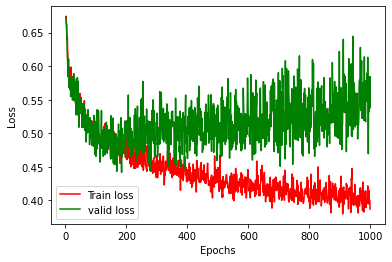

In [25]:
import matplotlib.pyplot as plt

plt.plot([i for i in range(1,epochs)],[i.cpu().detach().numpy() for i  in epoch_loss],label="Train loss",color="Red",)
plt.plot([i for i in range(1,epochs)],[j.cpu().detach().numpy() for j in valida_loss],label="valid loss",color="Green")
#plt.plot([i for i in range(1,epochs)],[i.cpu().detach().numpy() for i in test_loss],label="Test loss",color="Blue")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

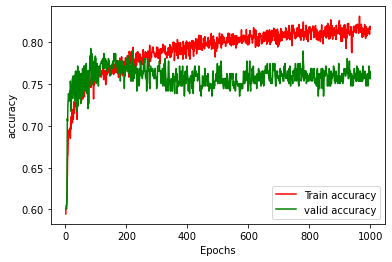

In [26]:
plt.plot([i for i in range(1,epochs)],[i  for i  in traine_accuracy],label="Train accuracy",color="Red",)
plt.plot([i for i in range(1,epochs)],[j for j in vale_accuracy],label="valid accuracy",color="Green")
#plt.plot([i for i in range(1,epochs)],[i.cpu().detach().numpy() for i in test_loss],label="Test loss",color="Blue")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("accuracy")
plt.show()

In [28]:
print(f"Training loss|   Mean: {torch.tensor(epoch_loss).mean()}   std: {torch.tensor(epoch_loss).std()}")
print(f"validation loss| Mean: {torch.tensor(valida_loss).mean()}  std: {torch.tensor(valida_loss).std()}")
print(f"Test loss|       Mean: {torch.tensor(test_loss).mean()}   std: {torch.tensor(test_loss).std()}")

Training loss|   Mean: 0.44508177042007446   std: 0.04588298127055168
validation loss| Mean: 0.5181114077568054  std: 0.03496598079800606
Test loss|       Mean: 0.5456082820892334   std: nan


C:\Users\Y-8874~1.EST\AppData\Local\Temp/ipykernel_21924/2757444226.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print(f"Test loss|       Mean: {torch.tensor(test_loss).mean()}   std: {torch.tensor(test_loss).std()}")
